In [ ]:
import os

import torch
from diffusers.image_processor import VaeImageProcessor
from huggingface_hub import snapshot_download
from PIL import Image

from catvton.model.cloth_masker import AutoMasker, vis_mask
from catvton.model.pipeline import CatVTONPipeline
from catvton.utils import init_weight_dtype
from catvton.preprocessor.image_processor import ImageProcessor
from typing import List, Literal


/home/binh/miniconda3/envs/catvton/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from pydantic import BaseModel

class InputRequest(BaseModel):
    person_files: List[str]
    cloth_files: List[str]
    cloth_type: Literal["upper", "lower", "overall"] = "upper"
    num_inference_steps: int = 10
    guidance_scale: float = 2.5  # minimum=0.0, maximum=7.5, step=0.5, value=2.5
    seed: int = 42
    show_type: Literal["result only", "input & result", "input & mask & result"] = "input & mask & result"
    batch_size: int = 4
    target_width: int = 768
    target_height: int = 1024
    


In [ ]:
base_model_path="booksforcharlie/stable-diffusion-inpainting"
output_dir="resource/demo/output"
allow_tf32=True
mixed_precision="bf16" #["no", "fp16", "bf16"]
resume_path="zhengchong/CatVTON"
repo_path = snapshot_download(repo_id=resume_path)



Fetching 10 files: 100%|██████████| 10/10 [00:00<00:00, 102801.57it/s]


In [3]:
pipeline = CatVTONPipeline(
    base_ckpt=base_model_path,
    attn_ckpt=repo_path,
    attn_ckpt_version="mix",
    weight_dtype=init_weight_dtype(mixed_precision),
    use_tf32=allow_tf32,
    device='cuda'
)
# AutoMasker
mask_processor = VaeImageProcessor(vae_scale_factor=8, do_normalize=False, do_binarize=True, do_convert_grayscale=True)
automasker = AutoMasker(
    densepose_ckpt=os.path.join(repo_path, "DensePose"),
    schp_ckpt=os.path.join(repo_path, "SCHP"),
    device='cuda', 
)


/home/binh/miniconda3/envs/catvton/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
An error occurred while trying to fetch booksforcharlie/stable-diffusion-inpainting: booksforcharlie/stable-diffusion-inpainting does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/home/binh/miniconda3/envs/catvton/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storage

In [ ]:
def inference(
    person_files: List[str],
    cloth_files: List[str],
    cloth_type: Literal["upper", "lower", "overall"]="upper",
    num_inference_steps: int=10,
    guidance_scale: float=2.5, # minimum=0.0, maximum=7.5, step=0.5, value=2.5
    seed: int =42,
    show_type: Literal["result only", "input & result", "input & mask & result"]="input & mask & result",,
    batch_size: int=4,
    target_width: int=768,
    target_height: int=1024
):

    MAX_IMAGES = 10
    person_images_paths = person_files[:MAX_IMAGES]
    cloth_images_paths = cloth_files[:MAX_IMAGES]

    # Preprocess person images
    person_images = ImageProcessor.preprocess_person_images(person_images_paths, (target_width, target_height))

    # Preprocess cloth images
    cloth_images = ImageProcessor.preprocess_cloth_images(cloth_images_paths, (target_width, target_height))

    # Generate masks for person images
    masks = ImageProcessor.generate_masks(person_images, cloth_type, automasker, mask_processor)

    # Generate combinations of person images and cloth images
    combinations = []
    for person_image, mask in zip(person_images, masks):
        for cloth_image in cloth_images:
            combinations.append((person_image, cloth_image, mask))

    results = []
    for i in range(0, len(combinations), batch_size):
        batch = combinations[i:i+batch_size]
        person_batch = [item[0] for item in batch]
        cloth_batch = [item[1] for item in batch]
        mask_batch = [item[2] for item in batch]

        # Convert images and masks to tensors
        person_tensors = ImageProcessor.images_to_tensor(person_batch).to(pipeline.device)
        cloth_tensors = ImageProcessor.images_to_tensor(cloth_batch).to(pipeline.device)
        mask_tensors = ImageProcessor.images_to_tensor(mask_batch).to(pipeline.device)

        print(f'person shape: {person_tensors.shape}')
        print(f'cloth shape: {cloth_tensors.shape}')
        print(f'mask shape: {mask_tensors.shape}')

        # Set random seed
        generator = None
        if seed != -1:
            generator = torch.Generator(device='cuda').manual_seed(seed)

        # Inference
        result_images = pipeline(
            person_tensors,
            cloth_tensors,
            mask_tensors,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            generator=generator
        )

        # Post-process results
        for idx, result_image in enumerate(result_images):
            person_image = person_batch[idx]
            cloth_image = cloth_batch[idx]
            mask = mask_batch[idx]

            if show_type == "result only":
                display_image = result_image
            else:
                width, height = person_image.size
                if show_type == "input & result":
                    condition_width = width // 2
                    conditions = ImageProcessor.image_grid([person_image, cloth_image], 2, 1)
                else:
                    masked_person = vis_mask(person_image, mask)
                    condition_width = width // 3
                    conditions = ImageProcessor.image_grid([person_image, masked_person , cloth_image], 3, 1)
                conditions = conditions.resize((condition_width, height), Image.NEAREST)
                new_result_image = Image.new("RGB", (width + condition_width + 5, height))
                new_result_image.paste(conditions, (0, 0))
                new_result_image.paste(result_image, (condition_width + 5, 0))
                display_image = new_result_image

            # Append result
            results.append(display_image)

    return results


In [5]:
768*0.8, 1025*0.8

(614.4000000000001, 820.0)

In [ ]:
person_files=["/home/binh/CatVTON/resource/demo/example/person/men/model_5.png"]
cloth_files=["/home/binh/CatVTON/resource/demo/example/condition/upper/21514384_52353349_1000.jpg"]
cloth_type = "upper" # ["upper", "lower", "overall"]
num_inference_steps=10
guidance_scale=2.5
# label="CFG Strength", minimum=0.0, maximum=7.5, step=0.5, value=2.5
seed=42
show_type="input & mask & result"
# choices=["result only", "input & result", "input & mask & result"],

# target_width=616
# target_height=820
# input size --> our size --> our size --> input size (present that to user)

target_width=768
target_height=1024

output_image = inference(person_files, cloth_files, cloth_type, num_inference_steps,target_width=target_width, target_height=target_height)



/home/binh/miniconda3/envs/catvton/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


person shape: torch.Size([1, 3, 1024, 768])
cloth shape: torch.Size([1, 3, 1024, 768])
mask shape: torch.Size([1, 1, 1024, 768])


100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


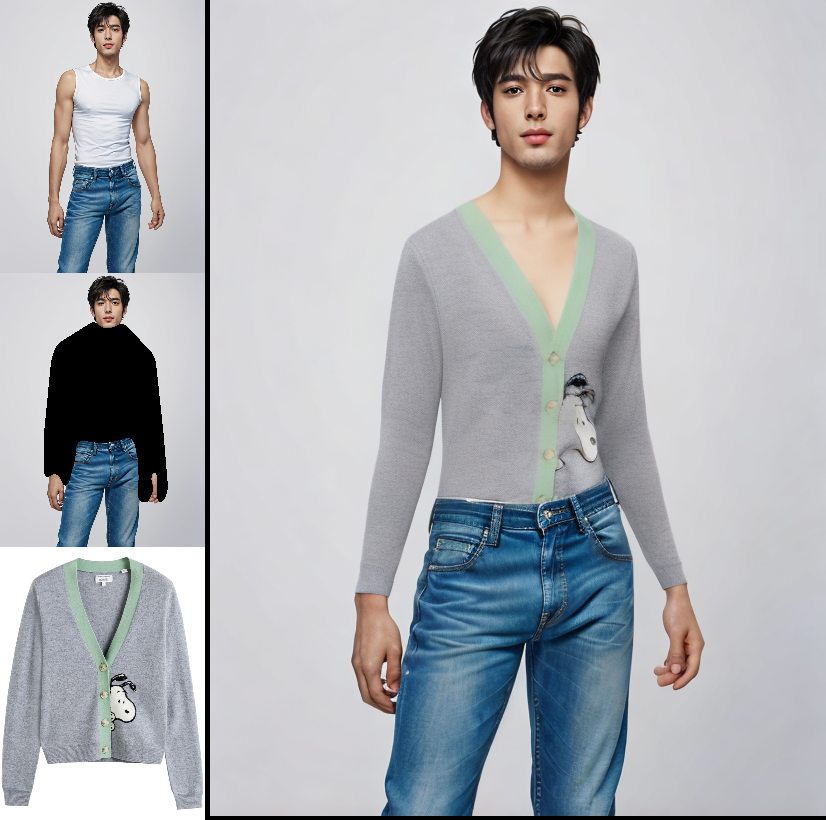

In [67]:
output_image[0]


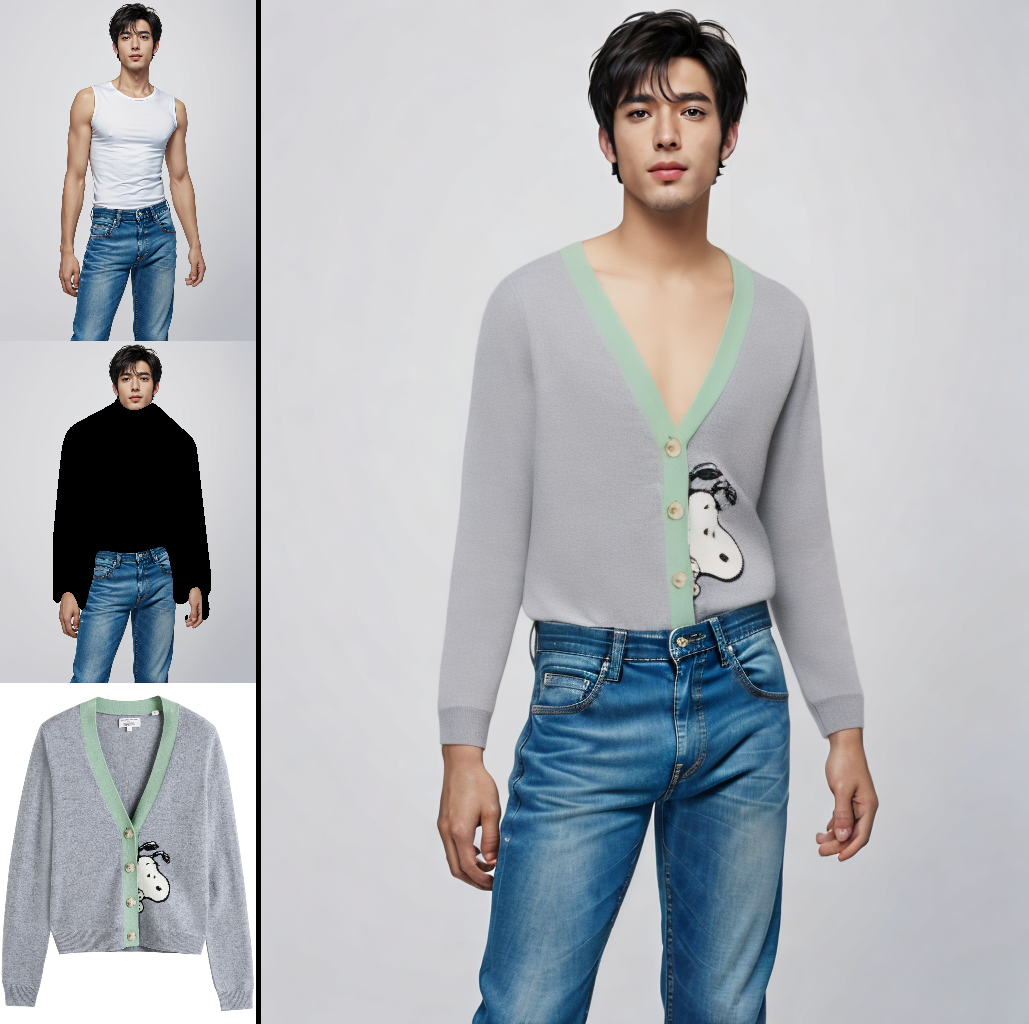

In [69]:
output_image[0]